# Maximizing the profit of an oil company

This tutorial includes everything you need to set up the decision optimization engines and build mathematical programming models.


When you finish this tutorial, you'll have a foundational knowledge of _Prescriptive Analytics_.

>This notebook is part of [Prescriptive Analytics for Python](http://ibmdecisionoptimization.github.io/docplex-doc/)
>
>It requires either an [installation of CPLEX Optimizers](http://ibmdecisionoptimization.github.io/docplex-doc/getting_started.html) or it can be run on [IBM Cloud Pak for Data as a Service](https://www.ibm.com/products/cloud-pak-for-data/as-a-service/) (Sign up for a [free IBM Cloud account](https://dataplatform.cloud.ibm.com/registration/stepone?context=wdp&apps=all>)
and you can start using `IBM Cloud Pak for Data as a Service` right away).
>
> CPLEX is available on <i>IBM Cloud Pack for Data</i> and <i>IBM Cloud Pak for Data as a Service</i>:
>    - <i>IBM Cloud Pak for Data as a Service</i>: Depends on the runtime used:
>         - <i>Python 3.x</i> runtime: Community edition
>         - <i>Python 3.x + DO</i> runtime: full edition
>    - <i>Cloud Pack for Data</i>: Community edition is installed by default. Please install `DO` addon in `Watson Studio Premium` for the full edition


Table of contents:

-  [Describe the business problem](#Describe-the-business-problem)
*  [How decision optimization (prescriptive analytics) can help](#How--decision-optimization-can-help)
*  [Use decision optimization](#Use-decision-optimization)
    *  [Step 1: Import the library](#Step-1:-Import-the-library)
    -  [Step 2: Model the data](#Step-2:-Model-the-data)
    *  [Step 3: Prepare the data](#Step-3:-Prepare-the-data)
    -  [Step 4: Set up the prescriptive model](#Step-4:-Set-up-the-prescriptive-model)
        * [Define the decision variables](#Define-the-decision-variables)
        * [Express the business constraints](#Express-the-business-constraints)
        * [Express the objective](#Express-the-objective)
        * [Solve with Decision Optimization](#Solve-with-Decision-Optimization)
    *  [Step 5: Investigate the solution and run an example analysis](#Step-5:-Investigate-the-solution-and-then-run-an-example-analysis)
*  [Summary](#Summary)


## Describe the business problem

* An oil company manufactures different types of gasoline and diesel. Each type of gasoline is produced by blending different types of crude oils that must be purchased. The company must decide how much crude oil to buy in order to maximize its profit while respecting processing capacities and quality levels as well as satisfying customer demand.

* Blending problems are a typical industry application of Linear Programming (LP). LP represents real life problems mathematically using an objective function to represent the goal that is to be minimized or maximized, together with a set of linear constraints which define the conditions to be satisfied and the limitations of the real life problem. The function and constraints are expressed in terms of decision variables and the solution, obtained from optimization engines such as IBM® ILOG® CPLEX®, provides the best values for these variables so that the objective function is optimized.

* The oil-blending problem consists of calculating different blends of gasoline according to specific quality criteria.

* Three types of gasoline are manufactured: super, regular, and diesel. 

* Each type of gasoline is produced by blending three types of crude oil: crude1, crude2, and crude3. 

* The gasoline must satisfy some quality criteria with respect to their lead content and their octane ratings, thus constraining the possible blendings.

* The company must also satisfy its customer demand, which is 3,000 barrels a day of super, 2,000 of regular, and 1,000 of diesel. 

* The company can purchase 5,000 barrels of each type of crude oil per day and can process at most 14,000 barrels a day.

* In addition, the company has the option of advertising a gasoline, in which case the demand for this type of gasoline increases by ten barrels for every dollar spent. 

* Finally, it costs four dollars to transform a barrel of oil into a barrel of gasoline.

## How  decision optimization can help
* Prescriptive analytics technology recommends actions based on desired outcomes, taking into account specific scenarios, resources, and knowledge of past and current events. This insight can help your organization make better decisions and have greater control of business outcomes.  

* Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

* Prescriptive analytics takes that insight to the next level by suggesting the optimal way to handle that future situation. Organizations that can act fast in dynamic conditions and make superior decisions in uncertain environments gain a strong competitive advantage.  
<br/>

+ For example:
    + Automate complex decisions and trade-offs to better manage limited resources.
    + Take advantage of a future opportunity or mitigate a future risk.
    + Proactively update recommendations based on changing events.
    + Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.


## Use decision optimization

### Step 1: Import the library

Run the following code to import the Decision Optimization CPLEX Modeling library.  The *DOcplex* library contains the two modeling packages, Mathematical Programming (docplex.mp) and Constraint Programming (docplex.cp).

In [1]:
import sys
try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')

If *CPLEX* is not installed, you can install CPLEX Community edition.

In [2]:
try:
    import cplex
except:
    raise Exception('Please install CPLEX. See https://pypi.org/project/cplex/')

### Step 2: Model the data

* For each type of crude oil, there are capacities of what can be bought, the buying price, the octane level, and the lead level. 
* For each type of gasoline or diesel, there is customer demand, selling prices, and octane and lead levels.
* There is a maximum level of production imposed by the factory's limit as well as a fixed production cost. 
* There are inventory costs for each type of final product and blending proportions. All of these have actual values in the model.

* The maginal production cost and maximum production are assumed to be identical for all oil types.


Input data comes as *NumPy* arrays with two dimensions. [NumPy](http://www.numpy.org/) is the fundamental package for scientific computing with Python.

The first dimension of the *NumPy* array is the number of gasoline types; 
and for each gasoline type, we have a *NumPy* array containing capacity, price, octane and lead level, in that order.

In [3]:
import numpy as np

gas_names = ["super", "regular", "diesel"]

gas_data = np.array([[3000, 70, 10, 1], [2000, 60, 8, 2], [1000, 50, 6, 1]])

oil_names = ["crude1", "crude2", "crude3"]

oil_data = np.array([[5000, 45, 12, 0.5], [5000, 35, 6, 2], [5000, 25, 8, 3]])

nb_gas  = len(gas_names)
nb_oils = len(oil_names)
range_gas = range(nb_gas)
range_oil = range(nb_oils)
print("Number of gasoline types = {0}".format(nb_gas))
print("Number of crude types = {0}".format(nb_oils))

# global data
production_cost = 4
production_max = 14000
# each $1 spent on advertising increases demand by 10.
advert_return = 10

Number of gasoline types = 3
Number of crude types = 3


### Step 3: Prepare the data

[Pandas](http://pandas.pydata.org/) is another Python library that we use to store data. *pandas* contains data structures and data analysis tools for the Python programming language.

In [4]:
import pandas as pd
gaspd = pd.DataFrame([(gas_names[i],int(gas_data[i][0]),int(gas_data[i][1]),int(gas_data[i][2]),int(gas_data[i][3])) 
                      for i in range_gas])
oilpd = pd.DataFrame([(oil_names[i],int(oil_data[i][0]),int(oil_data[i][1]),int(oil_data[i][2]),oil_data[i][3]) 
                      for i in range_oil])
gaspd.columns = ['name','demand','price','octane','lead']
oilpd.columns= ['name','capacity','price','octane','lead']

Use basic HTML and a stylesheet to format the data.

In [5]:
CSS = """
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}
    table.dataframe thead th:first-child {
        display: none;
    }
    table.dataframe tbody th {
        display: none;
    }
"""

from IPython.core.display import HTML
HTML('<style>{}</style>'.format(CSS))

Let's display the data we just prepared.

In [6]:
from IPython.display import display
print("Gas data:")
display(gaspd)
print("Oil data:")
display(oilpd)

Gas data:


,name,demand,price,octane,lead
0,super,3000,70,10,1
1,regular,2000,60,8,2
2,diesel,1000,50,6,1


Oil data:


,name,capacity,price,octane,lead
0,crude1,5000,45,12,0.5
1,crude2,5000,35,6,2.0
2,crude3,5000,25,8,3.0


### Step 4: Set up the prescriptive model

#### Create the DOcplex model
A model is needed to store all the variables and constraints needed to formulate the business problem and submit the problem to the solve service.

In [7]:
from docplex.mp.model import Model

mdl = Model(name="oil_blending")

#### Define the decision variables

For each combination of oil and gas, we have to decide the quantity of oil to use to produce a gasoline. A decision variable will be needed to represent that amount. 
A matrix of continuous variables, indexed by the set of oils and the set of gasolines needs to be created.


In [8]:
blends = mdl.continuous_var_matrix(keys1=nb_oils, keys2=nb_gas, lb=0)

We also have to decide how much should be spent in advertising for each time of gasoline. To do so, we will create a list of continuous variables, indexed by the gasolines.

In [9]:
adverts = mdl.continuous_var_list(nb_gas, lb=0)

#### Express the business constraints

The business constraints are the following:

* The demand for each gasoline type must be satisfied. The total demand includes the initial demand as stored in the data,plus a variable demand caused by the advertising. This increase is assumed to be proportional to the advertising cost.
- The capacity constraint on each oil type must also be satisfied.
- For each gasoline type, the octane level must be above a minimum level, and the lead level must be below a maximum level.

##### Demand

+ For each gasoline type, the total quantity produced must equal the raw demand plus the demand increase created by the advertising.

In [10]:
# gasoline demand is numpy array field #0
mdl.add_constraints(mdl.sum(blends[o, g] for o in range(nb_oils)) == gas_data[g][0] + advert_return * adverts[g]
                   for g in range(nb_gas))
mdl.print_information()

Model: oil_blending
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 3
   - linear=3
 - parameters: defaults
 - objective: none
 - problem type is: LP


##### Maximum capacity

+ For each type of oil, the total quantity used in all types of gasolines must not exceed the maximum capacity for this oil.

In [11]:
mdl.add_constraints(mdl.sum(blends[o,g] for g in range_gas) <= oil_data[o][0]
                    for o in range_oil)
mdl.print_information()

Model: oil_blending
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 6
   - linear=6
 - parameters: defaults
 - objective: none
 - problem type is: LP


##### Octane and Lead levels
+ For each gasoline type, the octane level must be above a minimum level, and the lead level must be below a maximum level.

In [12]:
# minimum octane level
# octane is numpy array field #2
mdl.add_constraints(mdl.sum(blends[o,g]*(oil_data[o][2] - gas_data[g][2]) for o in range_oil) >= 0
                   for g in range_gas)
    
# maximum lead  level
# lead level is numpy array field #3 
mdl.add_constraints(mdl.sum(blends[o,g]*(oil_data[o][3] - gas_data[g][3]) for o in range_oil) <= 0
                   for g in range_gas)

mdl.print_information()

Model: oil_blending
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 12
   - linear=12
 - parameters: defaults
 - objective: none
 - problem type is: LP


##### Maximum total production

+ The total production must not exceed the maximum (here 14000).

In [13]:
# -- maximum global production
mdl.add_constraint(mdl.sum(blends) <= production_max)

mdl.print_information()

Model: oil_blending
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 13
   - linear=13
 - parameters: defaults
 - objective: none
 - problem type is: LP


#### Express the objective

* The objective or goal is to maximize profit, which is made from sales of the final products minus total costs. The costs consist of the purchase cost of the crude oils, production costs, and inventory costs.
- The model maximizes the net revenue, that is revenue minus oil cost and production cost, to which we subtract the total advertising cost.
- To define business objective, let's define a few KPIs :
    * Total advertising cost
    - Total Oil cost
    - Total production cost
    - Total revenue

In [14]:
# KPIs
total_advert_cost = mdl.sum(adverts)
mdl.add_kpi(total_advert_cost, "Total advertising cost")
total_oil_cost = mdl.sum(blends[o,g] * oil_data[o][1] for o in range_oil for g in range_gas)
mdl.add_kpi(total_oil_cost, "Total Oil cost")
total_production_cost = production_cost * mdl.sum(blends)
mdl.add_kpi(total_production_cost, "Total production cost")
total_revenue = mdl.sum(blends[o,g] * gas_data[g][1] for g in range(nb_gas) for o in range(nb_oils))
mdl.add_kpi(total_revenue, "Total revenue")

# finally the objective
mdl.maximize(total_revenue - total_oil_cost - total_production_cost - total_advert_cost)

#### Solve with Decision Optimization

If you're using a Community Edition of CPLEX runtimes, depending on the size of the problem, the solve stage may fail and will need a paying subscription or product installation.

We display the objective and KPI values after the solve by calling the method report() on the model.

In [15]:
assert mdl.solve(), "Solve failed"
mdl.report()

* model oil_blending solved with objective = 287750.000
*  KPI: Total advertising cost = 750.000
*  KPI: Total Oil cost         = 487500.000
*  KPI: Total production cost  = 54000.000
*  KPI: Total revenue          = 830000.000


### Step 5: Investigate the solution and then run an example analysis

#### Displaying the solution
First, get the KPIs values and store them in a *pandas* DataFrame.

In [16]:
all_kpis = [(kp.name, kp.compute()) for kp in mdl.iter_kpis()]
kpis_bd = pd.DataFrame(all_kpis, columns=['kpi', 'value'])

In [17]:
blend_values = [ [ blends[o,g].solution_value for g in range_gas] for o in range_oil]
total_gas_prods = [sum(blend_values[o][g] for o in range_oil) for g in range_gas]

prods = list(zip(gas_names, total_gas_prods))
prods_bd = pd.DataFrame(prods)

Let's display some KPIs in pie charts using the Python package [*matplotlib*](http://matplotlib.org/).

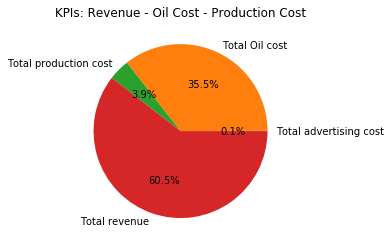

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
def display_pie(pie_values, pie_labels, colors=None,title=''):
    plt.axis("equal")
    plt.pie(pie_values, labels=pie_labels, colors=colors, autopct="%1.1f%%")
    plt.title(title)
    plt.show()
                                                           
display_pie( [kpnv[1] for kpnv in all_kpis], [kpnv[0] for kpnv in all_kpis],title='KPIs: Revenue - Oil Cost - Production Cost')

##### Production

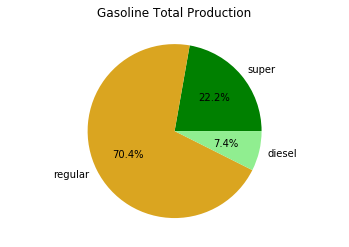

In [19]:
display_pie(total_gas_prods, gas_names, colors=["green", "goldenrod", "lightGreen"],title='Gasoline Total Production')

We see that the most produced gasoline type is by far regular.

Now, let's plot the breakdown of oil blend quantities per gasoline type.
We are using a multiple bar chart diagram, displaying all blend values for each couple of oil and gasoline type.

In [20]:
sblends = [(gas_names[n], oil_names[o], round(blends[o,n].solution_value)) for n in range_gas for o in range_oil]

blends_bd = pd.DataFrame(sblends)

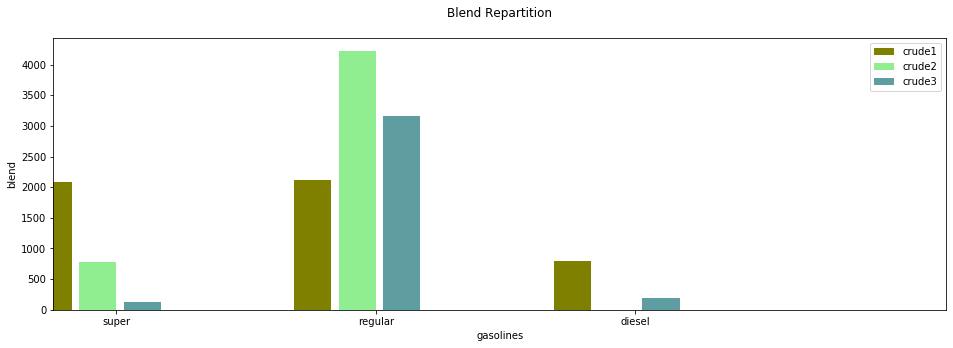

In [21]:
f, barplot = plt.subplots(1, figsize=(16,5))

bar_width = 0.1
offset = 0.12
rho = 0.7

# position of left-bar boundaries
bar_l = [o for o in range_oil]

mbar_w = 3*bar_width+2*max(0, offset-bar_width)

tick_pos = [b*rho + mbar_w/2.0 for b in bar_l]

colors = ['olive', 'lightgreen', 'cadetblue']

for i in range_oil:
    barplot.bar([b*rho + (i*offset) for b in bar_l], 
                blend_values[i], width=bar_width, color=colors[i], label=oil_names[i])

plt.xticks(tick_pos, gas_names)
barplot.set_xlabel("gasolines")
barplot.set_ylabel("blend")
plt.legend(loc="upper right")
plt.title('Blend Repartition\n')
                                                                          

# Set a buffer around the edge
plt.xlim([0, max(tick_pos)+mbar_w +0.5])

plt.show()

Notice the missing bar for (crude2, diesel) which is expected since blend[crude2, diesel] is zero in the solution.

We can check the solution value of blends for *crude2* and *diesel*, remembering that crude2 has offset 1 and diesel has offset 2.
Note how the decision variable is automatically converted to a float here. This would raise an exception if called before submitting a solve, as no solution value would be present.

In [22]:
print("* value of blend[crude2, diesel] is %g" % blends[1,2])

* value of blend[crude2, diesel] is 0


## Summary


You learned how to set up and use IBM Decision Optimization CPLEX Modeling for Python to formulate a Mathematical Programming model and solve it with CPLEX.

## References
* [CPLEX Modeling for Python documentation](http://ibmdecisionoptimization.github.io/docplex-doc/)
* [IBM Decision Optimization](https://www.ibm.com/analytics/decision-optimization)
* Need help with DOcplex or to report a bug? Please go [here](https://stackoverflow.com/questions/tagged/docplex).
* Contact us at dofeedback@wwpdl.vnet.ibm.com.

Copyright &copy; 2017-2022 IBM. IPLA licensed Sample Materials.